In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from abc import ABC, abstractmethod

#### Задаем seed для numpy

In [2]:
np.random.seed(0)

#### Функции потерь (3 шт.)

In [3]:
class LossFunction(ABC):
    @abstractmethod
    def calc_diff(self, result_tensor, target_tensor):
        pass

    @abstractmethod
    def get_name(self) -> str:
        pass


class MAE(LossFunction):
    def calc_diff(self, result_tensor, target_tensor):
        return np.mean(np.abs(target_tensor - result_tensor))

    def get_name(self) -> str:
        return "MAE"


class MSE(LossFunction):
    def calc_diff(self, result_tensor, target_tensor):
        return ((target_tensor - result_tensor)**2).mean()

    def get_name(self) -> str:
        return "MSE"
    

class CrossEntropyLoss(LossFunction):
    def calc_diff(self, result_tensor, target_tensor):
        epsilon = 1e-12
        predictions = np.clip(result_tensor, epsilon, 1. - epsilon)
        N = predictions.shape[0]
        ce = -np.sum(target_tensor*np.log(predictions+1e-9))/N
        return ce
    
    def get_name(self) -> str:
        return "CrossEntropyLoss"

#### Оптимизаторы (4 шт.)

In [4]:
class Optimizer:
    def __init__(self, learning_rate):
        self.lr = learning_rate


class SGD(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)


class MomentumSGD(Optimizer):
    def __init__(self, learning_rate, momentum_rate):
        super().__init__(learning_rate)
        self.momentum_rate = momentum_rate


class ClippingSGD(Optimizer):
    def __init__(self, learning_rate, clip_threshold):
        super().__init__(learning_rate)
        self.clip_threshold = clip_threshold


class AdaptiveSGD(Optimizer):
    def __init__(self, learning_rate, beta1, beta2, delta):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.delta = delta

#### Абстрактный класс слоя

In [5]:
class Layer(ABC):
    @abstractmethod
    def call(self, input_tensor):
        pass

    @abstractmethod
    def back(self, x, optim: Optimizer):
        pass

#### Слой с тензорами (матрицами)

In [6]:
class DenseLayer(Layer):
    def __init__(self, input_nodes, out_nodes):
        self.input_nodes = input_nodes
        self.out_nodes = out_nodes
        # тензор (матрица)
        self.layer = np.random.normal(0.0, pow(self.input_nodes, -0.5), (self.out_nodes, self.input_nodes))
        # храним тензоры для обратного распространения ошибок
        self.prev_tensor = None
        self.res_tensor = None
        # for momentum
        self.velocity = np.zeros_like(self.layer)
        # for adaptive
        self.m = np.zeros_like(self.layer)
        self.v = np.zeros_like(self.layer)
    
    # вызываем при проходе по слоям
    def call(self, input_tensor):
        self.prev_tensor = input_tensor.copy()
        return np.dot(self.layer, input_tensor)
    
    # для обратного распространения ошибок
    def back(self, x, optim: Optimizer):
        lr = optim.lr
        gradient = np.dot((x * self.res_tensor * (1.0 - self.res_tensor)), np.transpose(self.prev_tensor))

        if type(optim) is SGD:
            self.layer += lr * gradient
            return np.dot(self.layer.T, x)
        elif type(optim) is MomentumSGD:
            self.velocity = -optim.momentum_rate * self.velocity + lr * gradient
            self.layer += self.velocity
            return np.dot(self.layer.T, x)
        elif type(optim) is ClippingSGD:
            clipped_gradient = np.clip(gradient, -optim.clip_threshold, optim.clip_threshold)
            self.layer += lr * clipped_gradient
            return np.dot(self.layer.T, x)
        elif type(optim) is AdaptiveSGD:
            self.m = optim.beta1 * self.m + (1 - optim.beta1) * gradient
            self.v = optim.beta2 * self.v + (1 - optim.beta2) * (gradient ** 2)
            self.layer += -1 * (-lr * self.m / (np.sqrt(self.v) + optim.delta))
            return np.dot(self.layer.T, x)
        else:
            raise Exception("Unknown optim")

#### Слои активации (5 шт.)

In [7]:
class SigmoidLayer(Layer):
    def call(self, x):
        return 1 / (1 + np.exp(-x))
    
    def back(self, x, optim):
        return x


class TanhLayer(Layer):
    def call(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def back(self, x, optim):
        return x


class SoftPlusLayer(Layer):
    def call(self, x):
        return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
    
    def back(self, x, optim):
        return x
    

class ReluLayer(Layer):
    def call(self, x):
        return np.maximum(x, 0)
    
    def back(self, x, optim):
        return x


class SoftmaxLayer(Layer):
    def call(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x, axis=0)

    def back(self, x, optim):
        return x

#### Нейронная сеть

In [8]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers


    # приватная функция для тренировки батча
    def _train_batch(self, inputs_list, targets_list, batch_size, features_size, classes_size, 
                    optim: Optimizer):
        inputs = np.array(inputs_list).reshape(batch_size, features_size).T
        targets = np.array(targets_list).reshape(batch_size, classes_size).T

        cur_tensor = inputs.copy()
        # идём по слоям
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if isinstance(layer, (DenseLayer)):
                cur_tensor = layer.call(cur_tensor)
            elif isinstance(layer, (SigmoidLayer, TanhLayer, SoftPlusLayer, ReluLayer, SoftmaxLayer)):
                cur_tensor = layer.call(cur_tensor)
                # сохраням для обратного распространения ошибок
                self.layers[i-1].res_tensor = cur_tensor.copy()
            else:
                raise Exception(f'Unknown class type: {type(layer)}')

        # тензор до обратного распространения ошибок
        actual_tensor = cur_tensor.copy()
        output_error = targets - actual_tensor

        cur_tensor = output_error.copy()
        # запускаем обратное распространение ошибок
        for layer in self.layers[::-1]:
            cur_tensor = layer.back(cur_tensor, optim)
        return (actual_tensor, targets)


    # запустить тренировку 
    def start_train_batch(self, all_inputs, all_targets, batch_size, features_size, classes_size, 
                          optim: Optimizer, epochs, loss_func, plot=True):
        # история по эпохам
        errors_history = []

        for _ in range(epochs):
            # перемешиваем индексы
            indices = np.random.permutation(len(all_inputs))

            epoch_error = 0.0
            for i in range(0, len(all_inputs), batch_size):
                # формируем батчи
                batch_indices = indices[i:i+batch_size]
                batch_inputs_np = np.array([all_inputs[j] for j in batch_indices])
                batch_targets_np = np.array([all_targets[j] for j in batch_indices])
                result_tensor, target_tensor = self._train_batch(batch_inputs_np, batch_targets_np, batch_size, features_size, classes_size, optim)
                # считаем loss
                iter_error = loss_func.calc_diff(result_tensor, target_tensor)
                epoch_error += iter_error
            # делим loss на кол-во итераций
            iterations = math.ceil(len(all_inputs) / batch_size)
            errors_history.append(epoch_error / iterations)
        
        # отображаем график
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(list(range(1, epochs + 1)), errors_history)

            plt.title('Training Error History, method: ' + loss_func.get_name())
            plt.xlabel('Epoch')
            plt.ylabel('Error')
            plt.grid(True)
            plt.show()
            
    # получить 1 предсказание нейросети
    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        cur_tensor = inputs.copy()
        # идем по слоям
        for layer in self.layers:
            cur_tensor = layer.call(cur_tensor)
    
        return cur_tensor

    # провести тестирование
    def start_test(self, input_test, target_test):
        scorecard = []
        for x, y in zip(input_test, target_test):
            correct_label = y
            outputs = self.query(x)
            label = np.argmax(outputs)
            if label == correct_label:
                scorecard.append(1)
            else:
                scorecard.append(0)
        scorecard_array = np.asarray(scorecard)
        res = scorecard_array.sum() / scorecard_array.size
        return res

#### Пример с MNIST

ссылка на датасет <br>
http://www.pjreddie.com/media/files/mnist_train.csv <br>
http://www.pjreddie.com/media/files/mnist_test.csv

##### Начальные условия

In [9]:
features_size = 28 * 28
classes_size = 10
learning_rate = 0.1

layers = [DenseLayer(features_size, 200), SigmoidLayer(), DenseLayer(200, classes_size), SigmoidLayer()]
n = NeuralNetwork(layers)
optim = SGD(learning_rate)

# другие возможные параметры

#optim = MomentumSGD(0.1, 0.1)
#optim = ClippingSGD(learning_rate, 1.0)
#optim = AdaptiveSGD(learning_rate, 0.001, 0.001111, 0.9)

In [10]:
loss_func = MAE()

# другие возможные параметры

#loss_func = MSE()
#loss_func = CrossEntropyLoss()

#### Загрузка датасета

In [11]:
training_data_file = open("datasets/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [12]:
all_inputs = []
all_targets = []

for record in training_data_list:
    all_values = record.split(',')
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    targets = np.zeros(classes_size) + 0.01
    targets[int(all_values[0])] = 0.99
    all_inputs.append(inputs)
    all_targets.append(targets)

#### Тренировка нейросети

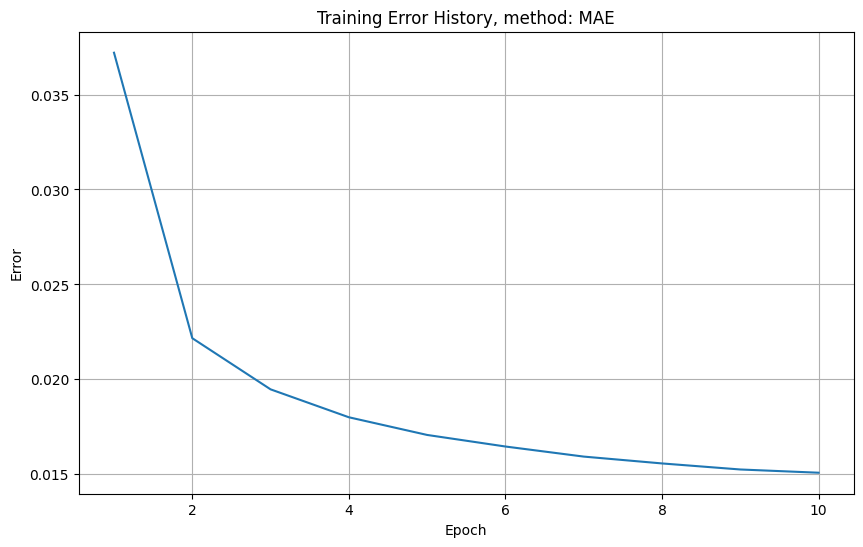

In [13]:
epochs = 10
batch_size = 16

n.start_train_batch(all_inputs, all_targets, batch_size, features_size, classes_size, optim,
                    epochs, loss_func)

#### Загрузка тестовой части датасета

In [14]:
test_data_file = open("datasets/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [15]:
input_test = []
target_test = []

for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    input_test.append(inputs)
    target_test.append(correct_label)

input_test = np.array(input_test)
target_test = np.array(target_test)

#### Тест и итоговый результат

In [16]:
res = n.start_test(input_test, target_test)
print(f'accuracy = {res}')

accuracy = 0.9736


#### Пример с IRIS

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X_train, X_test, _y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.33, random_state=42)

In [18]:
features_size = 4
classes_size = 3

learning_rate = 0.1

layers = [DenseLayer(features_size, 30), SigmoidLayer(), DenseLayer(30, classes_size), SigmoidLayer()]
n = NeuralNetwork(layers)
optim = SGD(learning_rate)
loss_func = MSE()

In [19]:
y_train = []

# устанавливаем вероятности для классов
for target in _y_train:
    targets = np.zeros(classes_size) + 0.01
    targets[target] = 0.99
    y_train.append(targets)

y_train = np.array(y_train)

#### Обучение

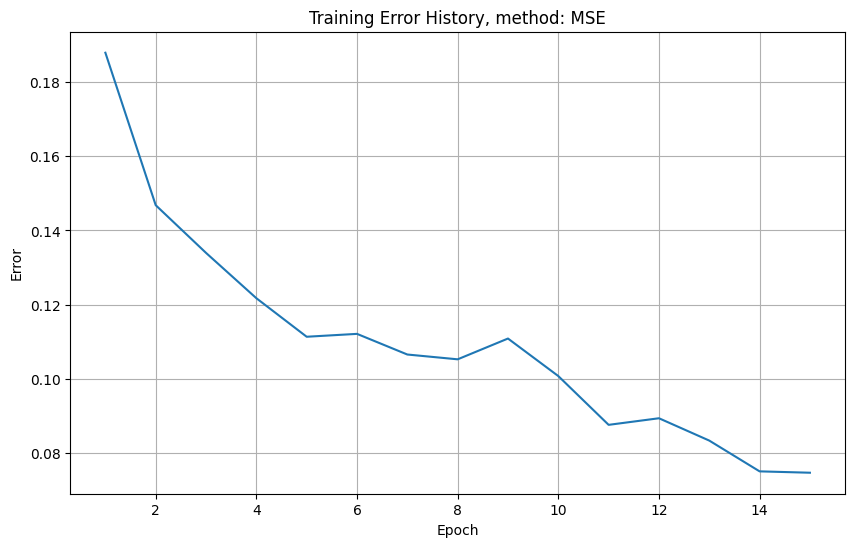

In [20]:
epochs = 15
batch_size = 4

n.start_train_batch(X_train, y_train, batch_size, features_size, classes_size, optim,
                    epochs, loss_func)

#### Тест и итоговый результат

In [21]:
res = n.start_test(X_test, y_test)
print (f"accuracy = {res}")

accuracy = 0.8


#### Пример с Mushroom

ссылка на датасет <br>
https://www.kaggle.com/datasets/uciml/mushroom-classification

In [22]:
import pandas as pd

data = pd.read_csv("datasets/mushrooms.csv")

In [23]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


#### Преобразование датасета

In [24]:
# меняем class values на "1" и "0"
data["class"] = [1 if i == "p" else 0 for i in data["class"]]

# убираем "veil-type" column
data.drop("veil-type",axis=1,inplace=True)

In [25]:
for column in data.drop(["class"], axis=1).columns:
    normalized_value = 0
    
    # вычисление шага
    step_size = 1 / (len(data[column].unique()) - 1)
    
    for unique_value in data[column].unique():
        data[column] = [normalized_value if val == unique_value else val for val in data[column]]
        
        normalized_value += step_size

In [26]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000000
1,0,0.0,0.000000,0.111111,0.0,0.125,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.2,0.166667
2,0,0.2,0.000000,0.222222,0.0,0.250,0.0,0.0,1.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.2,0.333333
3,1,0.0,0.333333,0.222222,0.0,0.000,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000000
4,0,0.0,0.000000,0.333333,1.0,0.375,0.0,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.125,0.4,0.166667


In [27]:
data = data.iloc[:-3]

In [28]:
x = data.drop(["class"], axis=1).values
y = data["class"].values    
X_train, X_test, _y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

#### Начальные условия

In [29]:
features_size = 21
classes_size = 2

learning_rate = 0.1

layers = [DenseLayer(features_size, 200), SoftmaxLayer(), DenseLayer(200, classes_size), SigmoidLayer()]
n = NeuralNetwork(layers)
optim = MomentumSGD(learning_rate, 0.1)
loss_func = CrossEntropyLoss()

In [30]:
y_train = []

# устанавливаем вероятности для классов
for target in _y_train:
    targets = np.zeros(classes_size) + 0.01
    targets[target] = 0.99
    y_train.append(targets)

y_train = np.array(y_train)

#### Обучение

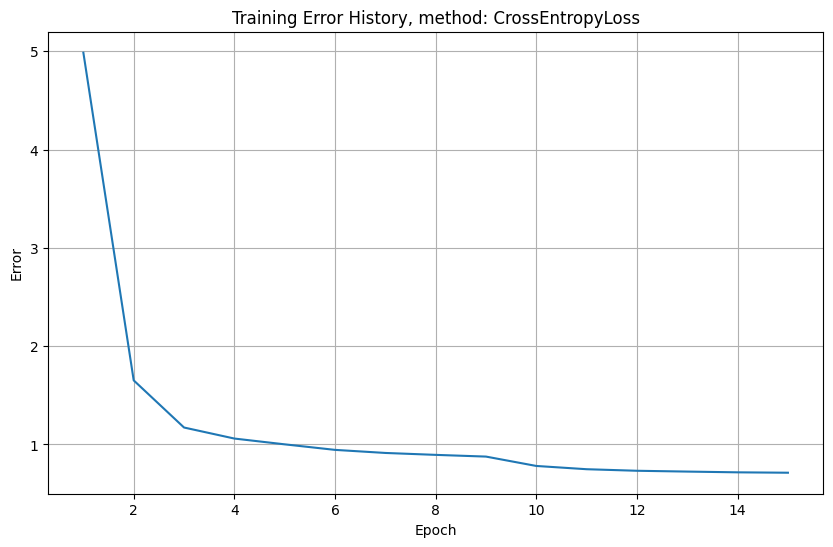

In [31]:
epochs = 15
batch_size = 16

n.start_train_batch(X_train, y_train, batch_size, features_size, classes_size, optim,
                    epochs, loss_func)

#### Тест и итоговый результат

In [32]:
res = n.start_test(X_test, y_test)
print (f"accuracy = {res}")

accuracy = 0.9778461538461538
